<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/experiment_model_improvement_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective
 - Improve accuracy of base model - classification task
 - use basic pretrained models to check accuracy - https://www.robots.ox.ac.uk/~albanie/pytorch-models.html - resnet50_face_sfew (weights)

Observations
  - xxx

Next Steps
  - lr finder
  - best model save
  - SE inclusion
Models
  - not saved

## Initializations
Cloning Repo, Dependencies installation, Libraries import and Config Initialization

### Cloning Repo, Installing dependencies

In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

fatal: destination path 'da_cv_fer' already exists and is not an empty directory.


In [2]:
!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)
ERROR: No matching distribution found for pywin32==306
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 7.0 MB/s eta 0:00:00


In [3]:
# Installs from files
from da_cv_fer.data_config import DataConfig
# from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP
# from da_cv_fer.ds_expw_crop import EXPWCROP
# from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import *
# from da_cv_fer.model_DANN import DANN
# from da_cv_fer.model_DANN_Bespoke import DANNBespoke
from da_cv_fer.run_config import RunConfig
from da_cv_fer.train import *
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np


### Initializing Configs

In [4]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

##  Dataset
- SFEW Dataset
- Creating Dataloader object


In [5]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Creating Dataloader

In [6]:
sfew = DatasetSFEWCROP()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew created successfully.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Happy.zip Happy
...completed for dataset/sfew/Train/Happy.zip
dataset/sfew/Train Sad.zip Sad
...completed for dataset/sfew/Train/Sad.zip
dataset/sfew/Train Disgust.zip Disgust
...completed for dataset/sfew/Train/Disgust.zip
dataset/sfew/Train Surprise.zip Surprise
...completed for dataset/sfew/Train/Surprise.zip
dataset/sfew/Train Fear.zip Fear
...completed for dataset/sfew/Train/Fear.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/Angry.zip
da

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Example Images

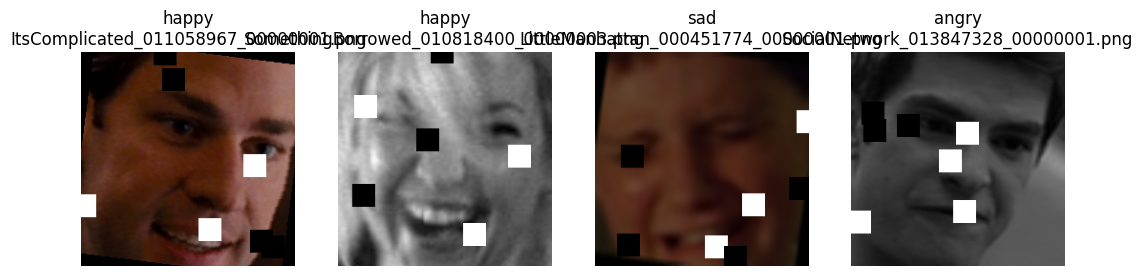

In [7]:
show_batch(sfew_train_loader,sfew.labels,4, normalized = False)

In [8]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
data_loader = {'source' : sfew_loader}
source_name = data_loader['source']['name']

## Model Initialization

### Simple Model_V4

In [9]:
# # only once done to load the weights to gdrive
# import requests

# weights_url = "http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/resnet50_face_sfew_dag.pth"
# weights_path = "/content/gdrive/MyDrive/CV_FER/weights/resnet50_face_sfew_dag.pth"

# response = requests.get(weights_url, allow_redirects=True)
# open(weights_path, 'wb').write(response.content)

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=False)  # Set pretrained=False to avoid downloading pre-trained weights

# Modify the last fully connected layer for your 7 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)  # Assuming 7 output classes

try:
  # Load your own weights
  weights_path = "/content/gdrive/MyDrive/CV_FER/weights/resnet50_face_sfew_dag.pth"
  state_dict = torch.load(weights_path)


  # Load the weights into the modified ResNet-50 model
  model.load_state_dict(state_dict)
except Exception as e:
  print(f"Error loading weights: {e}")

# Print the modified ResNet-50 architecture with your own weights
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Error loading weights: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight"

Minimum weight value: -0.09214474260807037
Maximum weight value: 0.09108129888772964


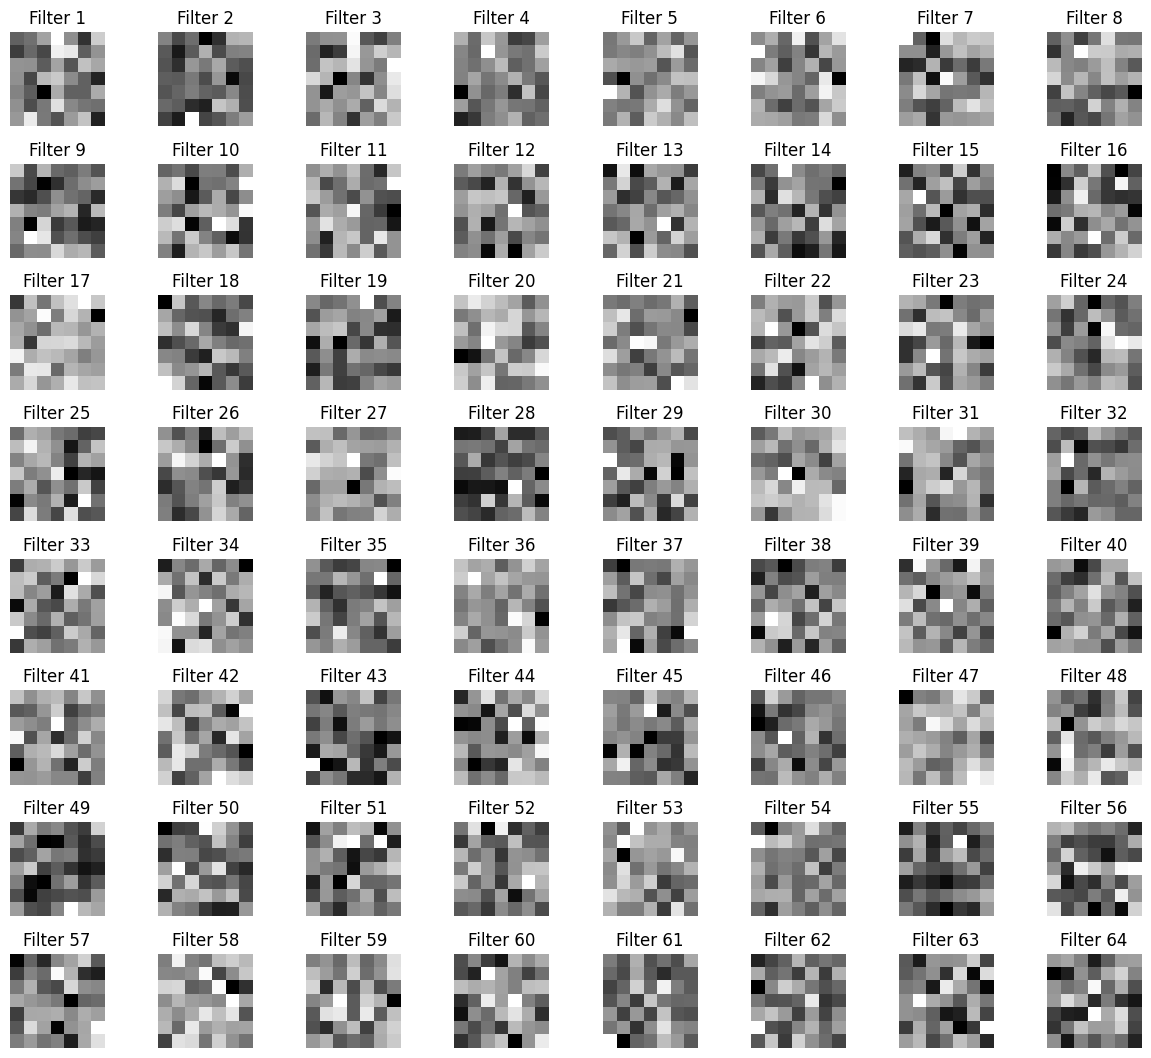

In [19]:
# Get the weights of the first convolutional layer
conv1_weights = model.conv1.weight.data

# Calculate the minimum and maximum values of the weights
min_value = conv1_weights.min().item()
max_value = conv1_weights.max().item()

print(f"Minimum weight value: {min_value}")
print(f"Maximum weight value: {max_value}")

# Visualize the filters
num_filters = conv1_weights.size(0)
num_cols = 8  # Number of columns in the grid
num_rows = num_filters // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))


for i in range(num_filters):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    filter_weights = conv1_weights[i].cpu().numpy()
    # print(f'{i}:{filter_weights}')
    ax.imshow(filter_weights.mean(axis=0), cmap='gray')  # Plot the mean of the filter weights
    ax.axis('off')
    ax.set_title(f'Filter {i+1}')

# Remove empty subplots
for i in range(num_filters, num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

In [20]:
import torch
import torch.nn as nn


class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31)
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction




def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

vgg = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")


In [21]:
print(vgg)

Vgg_vd_face_sfew_dag(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_m

Minimum weight value: -0.3211316466331482
Maximum weight value: 0.35635191202163696


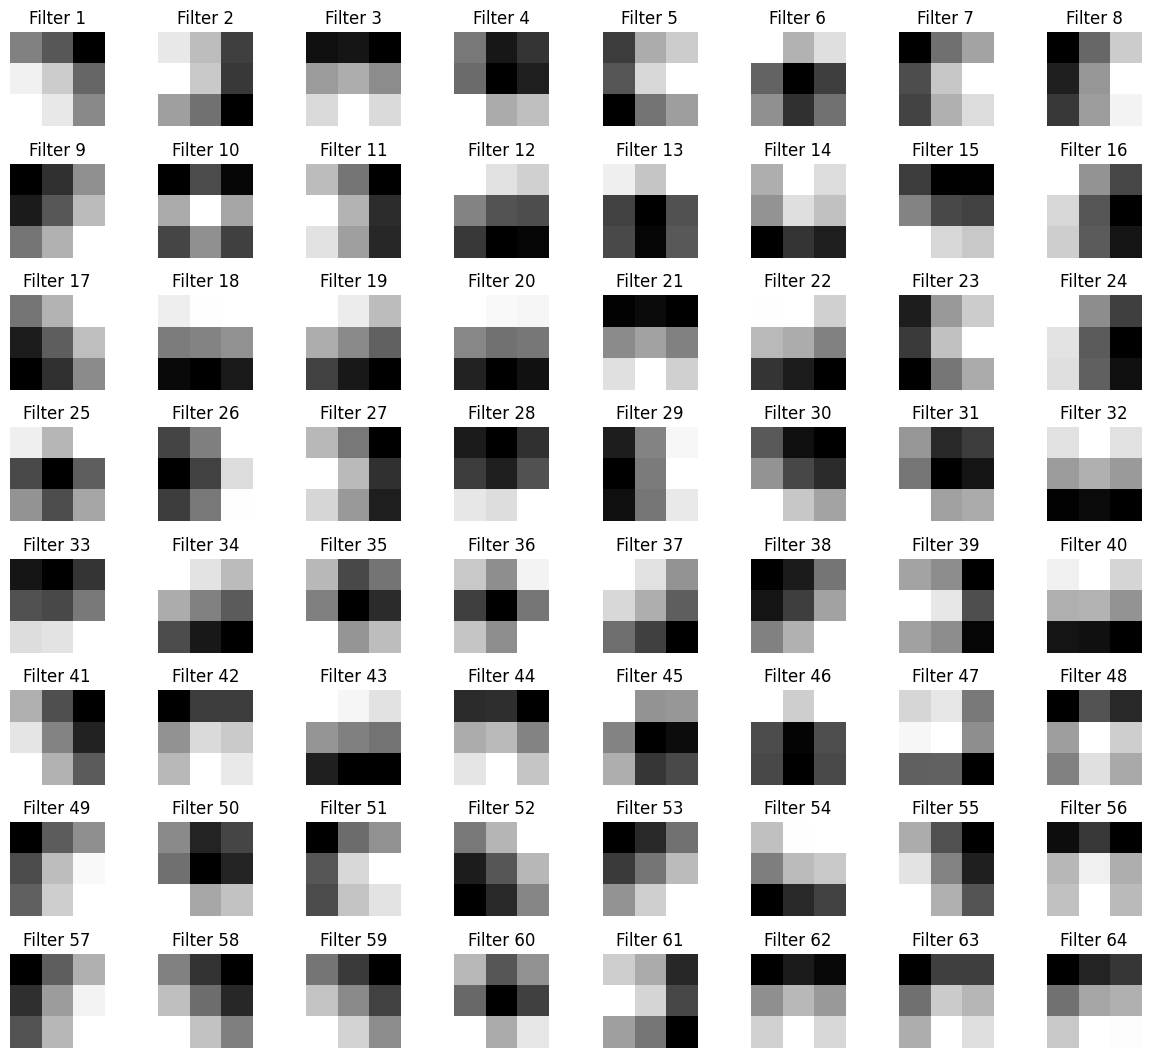

In [23]:
# Get the weights of the first convolutional layer
conv1_weights = vgg.conv1_1.weight.data

# Calculate the minimum and maximum values of the weights
min_value = conv1_weights.min().item()
max_value = conv1_weights.max().item()

print(f"Minimum weight value: {min_value}")
print(f"Maximum weight value: {max_value}")

# Visualize the filters
num_filters = conv1_weights.size(0)
num_cols = 8  # Number of columns in the grid
num_rows = num_filters // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))


for i in range(num_filters):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    filter_weights = conv1_weights[i].cpu().numpy()
    # print(f'{i}:{filter_weights}')
    ax.imshow(filter_weights.mean(axis=0), cmap='gray')  # Plot the mean of the filter weights
    ax.axis('off')
    ax.set_title(f'Filter {i+1}')

# Remove empty subplots
for i in range(num_filters, num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

## Checking accuracy before fine tuning

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [12]:
model = model.to(device=device)

In [13]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [14]:
def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            # class_output  = model((images*255)) # forward pass, output = {class}
            class_output  = model((images)) # forward pass, output = {class}

            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss

In [15]:
correct, test_loss = test_model_local(model, device, data_loader['source']['val'], mode= 'test')
correct, test_loss

Test / Val: Average loss: 0.4515, Accuracy: 72/419 (17.18%)



(72, 0.4515457039516695)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

def train_model_local(model, train_loader, criterion, optimizer, device='cuda'):
    model.to(device)
    model.train()


    # for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0

    for inputs, labels,_ in train_loader:
        # inputs = inputs * 255.0  # Convert inputs from [0, 1] to [0, 255]
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += get_correct_preds(outputs, labels)


    epoch_loss = running_loss / len(train_loader.dataset)
    length_dataset = len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy : {correct}/{length_dataset} Or {100. * correct / length_dataset}')

    # print('Training finished.')




In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [48]:
num_epochs=55
for epoch in range(num_epochs):
  train_model_local(model = model, train_loader = data_loader['source']['train'], criterion = criterion, optimizer=optimizer)
  test_model_local(model, device, data_loader['source']['val'], class_loss_function= criterion, mode= 'test')

Epoch [1/55], Loss: 5.7419, Accuracy : 167/913 Or 18.291347207009856
Test / Val: Average loss: 0.4439, Accuracy: 71/419 (16.95%)

Epoch [2/55], Loss: 2.6166, Accuracy : 160/913 Or 17.524644030668128
Test / Val: Average loss: 0.5060, Accuracy: 72/419 (17.18%)

Epoch [3/55], Loss: 2.2735, Accuracy : 160/913 Or 17.524644030668128
Test / Val: Average loss: 0.6131, Accuracy: 71/419 (16.95%)

Epoch [4/55], Loss: 2.1549, Accuracy : 171/913 Or 18.729463307776562
Test / Val: Average loss: 0.1503, Accuracy: 75/419 (17.90%)

Epoch [5/55], Loss: 2.1305, Accuracy : 154/913 Or 16.867469879518072
Test / Val: Average loss: 0.2482, Accuracy: 80/419 (19.09%)

Epoch [6/55], Loss: 2.0065, Accuracy : 172/913 Or 18.838992332968235
Test / Val: Average loss: 0.7363, Accuracy: 62/419 (14.80%)

Epoch [7/55], Loss: 2.0695, Accuracy : 182/913 Or 19.934282584884993
Test / Val: Average loss: 0.1477, Accuracy: 75/419 (17.90%)

Epoch [8/55], Loss: 2.0157, Accuracy : 187/913 Or 20.481927710843372
Test / Val: Average l

KeyboardInterrupt: 

In [ ]:
# import torch.nn as nn
# # import torch
# import torch.nn.functional as F

# class SimpleModelv1(nn.Module):
#     def __init__(self,
#                  num_classes = 7,
#                  dropout = 0.1):

#         super(SimpleModelv1, self).__init__()
#         self.num_classes = num_classes

#         #---------------------Feature Extractor Network------------------------#
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # 224>224 | 3
#         self.conv2 = nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3, padding= 1) # 224>224 | 5
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 224>112 | 10

#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # 112>112 | 12
#         self.conv4 = nn.Conv2d(in_channels=128,out_channels=256, kernel_size=3, padding= 1) # 112>112 | 14
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 112>56 | 28

#         self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1) # 56>56 | 30
#         self.conv6 = nn.Conv2d(in_channels=512,out_channels=1024, kernel_size=3, padding= 1) # 56>56 | 32
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 56>28 | 64

#         self.conv7 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, padding=1) # 28>28 | 66
#         self.conv8 = nn.Conv2d(in_channels=2048,out_channels=2048, kernel_size=3, padding= 1) # 28>28 | 68
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 28>14 | 136

#         self.conv9 = nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=3, padding=1) # 14>14 | 138
#         self.conv10 = nn.Conv2d(in_channels=512,out_channels=128, kernel_size=3, padding= 1) # 14>14 | 140
#         self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2) # 14>7 | 280

#         self.conv11 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3) # 7>5 | 282
#         self.conv12 = nn.Conv2d(in_channels=32,out_channels=16, kernel_size=3) # 5>3 | 284
#         self.conv13 = nn.Conv2d(in_channels=16,out_channels=self.num_classes, kernel_size=3) # 3>1x1xnum_classes | 286

#         # #---------------------Class (Task) Classifier Network------------------------#

#         # class_classifier_layers = [nn.ReLU(),
#         #                            nn.Dropout(p=dropout),
#         #                            nn.Linear(1280,100),
#         #                            nn.ReLU(),
#         #                            nn.Dropout(p=dropout)]

#         # class_classifier_layers.extend([nn.ReLU(),
#         #                                 nn.Dropout(p=dropout),
#         #                                 nn.Linear(100,num_classes)])

#         # self.class_classifier = nn.Sequential(*class_classifier_layers)
#         # print (self.class_classifier)

#     def forward(self, x):
#         x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
#         # print("after first max pool, shape :", x.shape)
#         x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
#         # print("after second max pool, shape :", x.shape)
#         x = self.pool3(F.relu(self.conv6(F.relu(self.conv5(x)))))
#         # print("after third max pool, shape :", x.shape)
#         x = self.pool4(F.relu(self.conv8(F.relu(self.conv7(x)))))
#         # print("after fourth max pool, shape :", x.shape)
#         x = self.pool5(F.relu(self.conv10(F.relu(self.conv9(x)))))
#         # print("after fifth max pool, shape :", x.shape)
#         x = self.conv13(F.relu(self.conv12(F.relu(self.conv11(x)))))
#         # print("after convolution shape :", x.shape)

#         x = x.view(-1, self.num_classes)
#         # print("after reshaping - view shape :", x.shape)
#         return x
#         # return F.log_softmax(x, dim=1)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class SimpleModelv2(nn.Module):
    def __init__(self,
                 num_classes = 7,
                 dropout = 0.1):

        super(SimpleModelv2, self).__init__()

        self.num_classes = num_classes
        resnet = models.resnet50(pretrained=True)
        num_features = resnet.fc.in_features
        resnet.fc = nn.Linear(num_features, num_classes)
        self.resnet = resnet

    def forward(self, x):
        x = self.resnet(x)
        return x,x,x

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

In [ ]:
model = SimpleModelv2().to(device=device)

#### Model params

In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

In [ ]:
# print(model)

#### Running Model for single Run

In [ ]:
for usage, dict_data_loader in data_loader.items(): ## {'source' : sfew_loader,'target' : expw_loader}
    print('-'*80)
    print(usage)
    for k, v in dict_data_loader.items(): # {'name': 'sfew','train':sfew_train_loader,'val':sfew_val_loader}
      if k == 'name':
        print (f'--------{k} of dataset : {v}--------')
      else:
        print (f'   --------type : {k}--------')
        batch = next(iter(v)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
        images, labels = batch[0].to(device), batch[1].to(device)
        print( "Input:\n","Input Image: ",images.shape, ", labels: ",labels.shape)
        print("Input labels:\n", labels)
        print("Input labels - index", labels.argmax(dim=1))

        x_labels, _ , _ = model(images) # forward pass
        print("Output:\n", "labels shape: ", x_labels.shape)
        print("Output labels:\n", x_labels)
        print("Output labels - index", x_labels.argmax(dim=1))


## Training and Testing

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

### Train Function

In [ ]:
# import torch.nn as nn
# def train(model, device, train_loader,
#           optimizer, epoch,
#           # loss_fn = F.cross_entropy
#           # loss_fn = F.nll_loss
#           # loss_fn = F.binary_cross_entropy_with_logits
#           loss_fn = nn.CrossEntropyLoss()

#           ):
#   model.train()
#   pbar = tqdm(train_loader)
#   correct = 0
#   processed = 0
#   for batch_idx, (data, target,img_name) in enumerate(pbar):
#     # get samples
#     data, target = data.to(device), target.to(device)

#     # Init
#     optimizer.zero_grad()

#     # Predict
#     y_pred = model(data)

#     # Calculate loss
#     loss = loss_fn(y_pred, target)
#     train_losses.append(loss)

#     # Backpropagation
#     loss.backward()
#     optimizer.step()

#     # Update pbar-tqdm

#     pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#     # correct += pred.eq(target.view_as(pred)).sum().item()
#     correct += (pred.argmax(dim=1).eq(target.argmax(dim=1))).sum().item()

#     processed += len(data)

#     pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
#     train_acc.append(100*correct/processed)

### Test Function

In [ ]:
# def test(model, device, test_loader,
#         #  loss_fn = F.cross_entropy
#         #  loss_fn = F.nll_loss
#         #  loss_fn = F.binary_cross_entropy_with_logits
#         loss_fn = nn.CrossEntropyLoss()
#          ):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target, img_name in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += loss_fn(output, target).item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += (pred.argmax(dim=1).eq(target.argmax(dim=1))).sum().item()

#     test_loss /= len(test_loader.dataset)
#     test_losses.append(test_loss)

#     print('--Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

#     test_acc.append(100. * correct / len(test_loader.dataset))

### Execution

In [ ]:
runconfig = RunConfig()
device = runconfig.device
model = SimpleModelv2().to(device=device)
best_model = SimpleModelv2().to(device=device)


#learning rate
lr =  0.01 #float(runconfig.inital_lr)

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
# EPOCHS = 5 #override
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

#optimizer with weight decay (L2 regularization)
# optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9, weight_decay= 0.0001)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

# Initialize variables to track the best validation loss and the best model state
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
# criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based
list_val_correct = [] # to capture validation accuracy over epochs
list_best_val_correct = [] # to capture best validtion accuracy over epochs

In [ ]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model(model = model,
                                          device = device,
                                          data_loader = data_loader['source']['train'],
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    #Validate Model
    correct, avg_epoch_val_loss = test_model(model= model,
                                    device= device,
                                    data_loader = data_loader['source']['val'],
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)
    list_val_correct.append(correct)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct

    # # Check if the current model has the best validation loss
    # print(f'Last Epoch Val Loss = {avg_epoch_val_loss} | Best Val Loss = {best_val_loss}' )
    # if avg_epoch_val_loss < best_val_loss:
    #   best_val_loss = avg_epoch_val_loss
    #   # save the current model state as the best model state
    #   best_model_state = deepcopy(non_dann_model.state_dict())
    #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

    # check if the current model has the best accuracy
    print (f'last correct ={correct} | best correct = {best_val_acc}')
    if correct > best_val_acc:
      best_val_acc = correct
      # save the current model state as the best model state
      best_model_state = deepcopy(model.state_dict())
      print(f'Updated the best model with correct: {correct}\n')

    list_best_val_correct.append(best_val_acc)

    # early stopping
    # if early_stopping_difference(val_losses,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    if early_stopping_difference(list_val_correct,
                                 patience = early_stop_patience,
                                 difference= early_stop_difference):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

    if early_stopping_difference(list_best_val_correct,
                                 patience = 2*early_stop_patience,
                                 difference= 0):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break



    ## showing misclassification images after every 10 epochs
    if epoch % 10 == 0:
      list_misclassified_images = get_misclassified_images_list(model= model,
                                                                device = device,
                                                                test_loader = data_loader['source']['val'],
                                                                num_image = 10)
      plot_misclassified_images(list_misclassified_images)

## using params of best model to update model
if best_model_state: # only update if best model has been saved, else the last one would be picked up
  # best_non_dann_model.load_state_dict(best_model_state)
  best_model.load_state_dict(best_model_state)
  print('Best model loaded')


print(f'Validation results with {source_name}')

correct, test_loss_source = test_model(model= best_model, #best_non_dann_model, #non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'], # source val loader
                                    class_loss_function = criterion_class)


dict_non_dann_losses = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                       'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}


In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t_items.item() for t_items in dict_non_dann_losses['train_losses']])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot([t_items.item() for t_items in dict_non_dann_losses['train_losses']])
axs[1, 0].set_title("WIP Training Accuracy")
axs[0, 1].plot(dict_non_dann_losses['val_losses'])
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(dict_non_dann_losses['val_losses'])
axs[1, 1].set_title("WIP Test Accuracy")